### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/RTide/

/content/drive/My Drive/RTide


In [3]:
!pip install utide

In [4]:
!pip install skyfield

In [5]:
!pip install shap

### Loading Data

In [6]:
import rtide
from rtide import RTide

/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


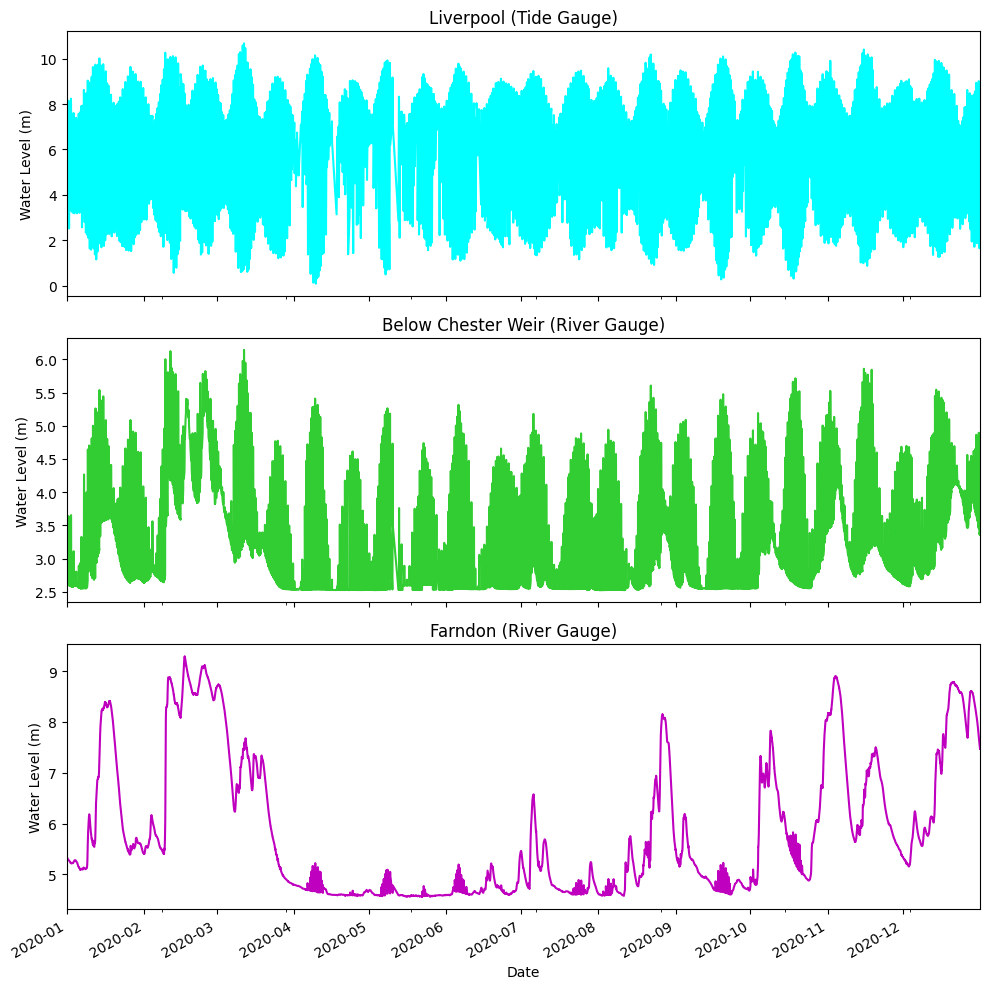

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

dir = "./examples/data/"
ds_c = xr.open_dataset(dir + "ctr2_2020.nc")
ds_f = xr.open_dataset(dir + "farn_2020.nc")
ds_l = xr.open_dataset(dir + "liv_2020.nc")

# Convert datasets to pandas DataFrames with datetime index
df_c = ds_c.sea_level.to_dataframe().reset_index().set_index('time')
df_f = ds_f.sea_level.to_dataframe().reset_index().set_index('time')
df_l = ds_l.sea_level.to_dataframe().reset_index().set_index('time')

# Ensure the index is of datetime type
df_c.index = pd.to_datetime(df_c.index, utc = True)
df_f.index = pd.to_datetime(df_f.index, utc = True)
df_l.index = pd.to_datetime(df_l.index, utc = True)

# Rename the sea_level columns to distinguish them
df_c.rename(columns={'sea_level': 'observations'}, inplace=True)
df_f.rename(columns={'sea_level': 'River_level_upstream'}, inplace=True)
df_l.rename(columns={'sea_level': 'Liverpool'}, inplace=True)

# Combine all DataFrames into a single DataFrame
df = pd.concat([df_c, df_f, df_l], axis=1)


df = df.dropna()

# Plot the data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

df['Liverpool'].plot(ax=axes[0], color='cyan')
axes[0].set_title('Liverpool (Tide Gauge)')
axes[0].set_ylabel('Water Level (m)')

df['observations'].plot(ax=axes[1], color='limegreen')
axes[1].set_title('Below Chester Weir (River Gauge)')
axes[1].set_ylabel('Water Level (m)')

df['River_level_upstream'].plot(ax=axes[2], color='m')
axes[2].set_title('Farndon (River Gauge)')
axes[2].set_ylabel('Water Level (m)')
axes[2].set_xlabel('Date')

axes[0].set_xlim(df.index[0], df.index[-1])
axes[1].set_xlim(df.index[0], df.index[-1])
axes[2].set_xlim(df.index[0], df.index[-1])

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


### Running RTide:

In [8]:
df = pd.concat([df_c, df_f], axis=1)

df = df.dropna()

In [17]:
model = RTide(df[:20000], lat = 53.1109, lon = -2.53175) ## let's assume we have access to the first 20,000 measurements.

In [18]:
inputs = {
    'symmetrical': True,
    'sample_rate': 4,
    'path':'river'
}

model.Prepare_Inputs(**inputs)

Input function path either has not specified, has not yet been computed, or different inputs were provided. Computing now...
Actual error was [Errno 2] No such file or directory: './rtide_saves/river_global_tide.csv'


100%|██████████| 30698/30698 [09:35<00:00, 53.36it/s]


#### Model Overview ####
Learning Rate: 0.0001
Loss: MSE
Linear Epochs: 0
Standard Epochs: 500
Regularization: 0.001
Number of Layers: 3
Multi: True
Save Weights: True
Epoch 1/500
532/532 - 2s - loss: 1.2121 - val_loss: 0.7345 - lr: 1.0000e-04 - 2s/epoch - 4ms/step
Epoch 2/500
532/532 - 2s - loss: 0.7045 - val_loss: 0.6850 - lr: 1.0000e-04 - 2s/epoch - 4ms/step
Epoch 3/500
532/532 - 2s - loss: 0.6532 - val_loss: 0.6552 - lr: 1.0000e-04 - 2s/epoch - 5ms/step
Epoch 4/500
532/532 - 2s - loss: 0.6335 - val_loss: 0.6354 - lr: 1.0000e-04 - 2s/epoch - 4ms/step
Epoch 5/500
532/532 - 1s - loss: 0.6126 - val_loss: 0.6412 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 6/500
532/532 - 1s - loss: 0.5994 - val_loss: 0.6133 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 7/500
532/532 - 2s - loss: 0.5956 - val_loss: 0.5973 - lr: 1.0000e-04 - 2s/epoch - 3ms/step
Epoch 8/500
532/532 - 2s - loss: 0.5727 - val_loss: 0.5672 - lr: 1.0000e-04 - 2s/epoch - 3ms/step
Epoch 9/500
532/532 - 1s - loss: 0.5575 - val_lo

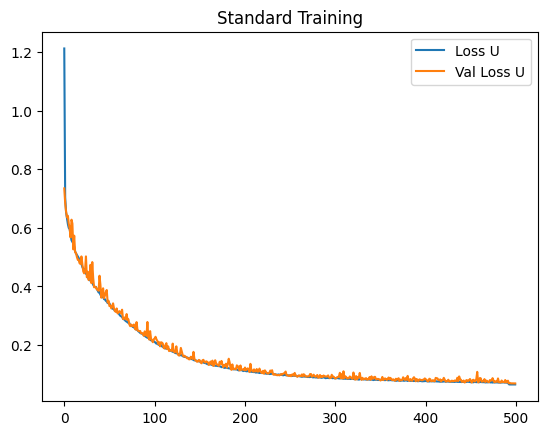

625/625 [==============================] - 1s 2ms/step


In [28]:
train_inputs = {
    'loss' : 'MSE',
    'lr' : 1e-04,
    'standard_epochs' : 500,
    'hidden_nodes' : 'standard',
    'depth' : 3,
    'early_stoppage' : 50,
    'save_weights' : True,
    'regularization_strength' : 0.001
}

model.Train(**train_inputs)

In [29]:
model.Predict(df[20000:21500])

Computing input functions for prediction
Input function path either has not specified, has not yet been computed, or different inputs were provided. Computing now...
Actual error was exceptions must derive from BaseException


100%|██████████| 2736/2736 [00:47<00:00, 57.38it/s]


47/47 [==============================] - 0s 3ms/step


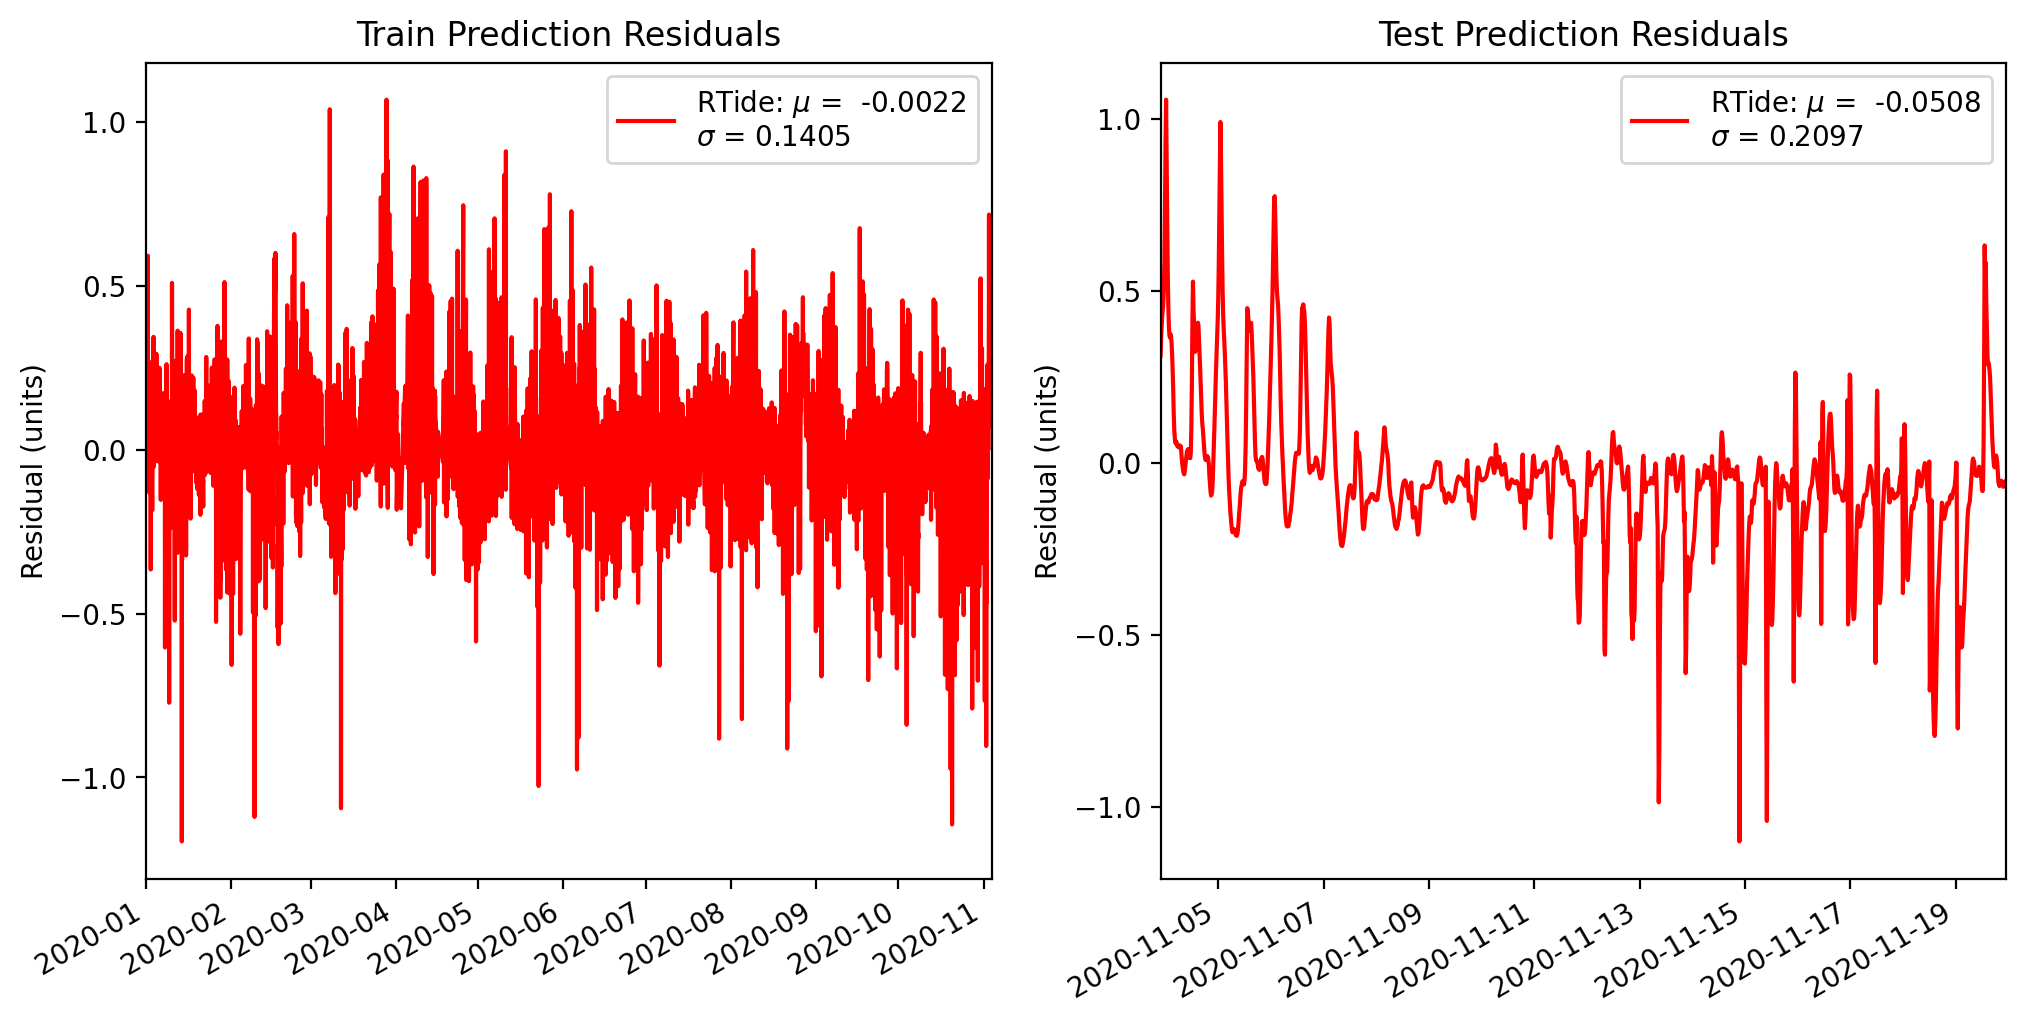

In [30]:
model.Visualize_Residuals()

Train Results
r2: 0.9665890867510123 MSE: 0.019753661979816643 MAE : 0.08924467641830444 MAPE : 0.025831744035754035
Test Results
r2: 0.9131422674004742 MSE: 0.046548426609286715 MAE : 0.14101299114100138 MAPE : 0.03705889869491863


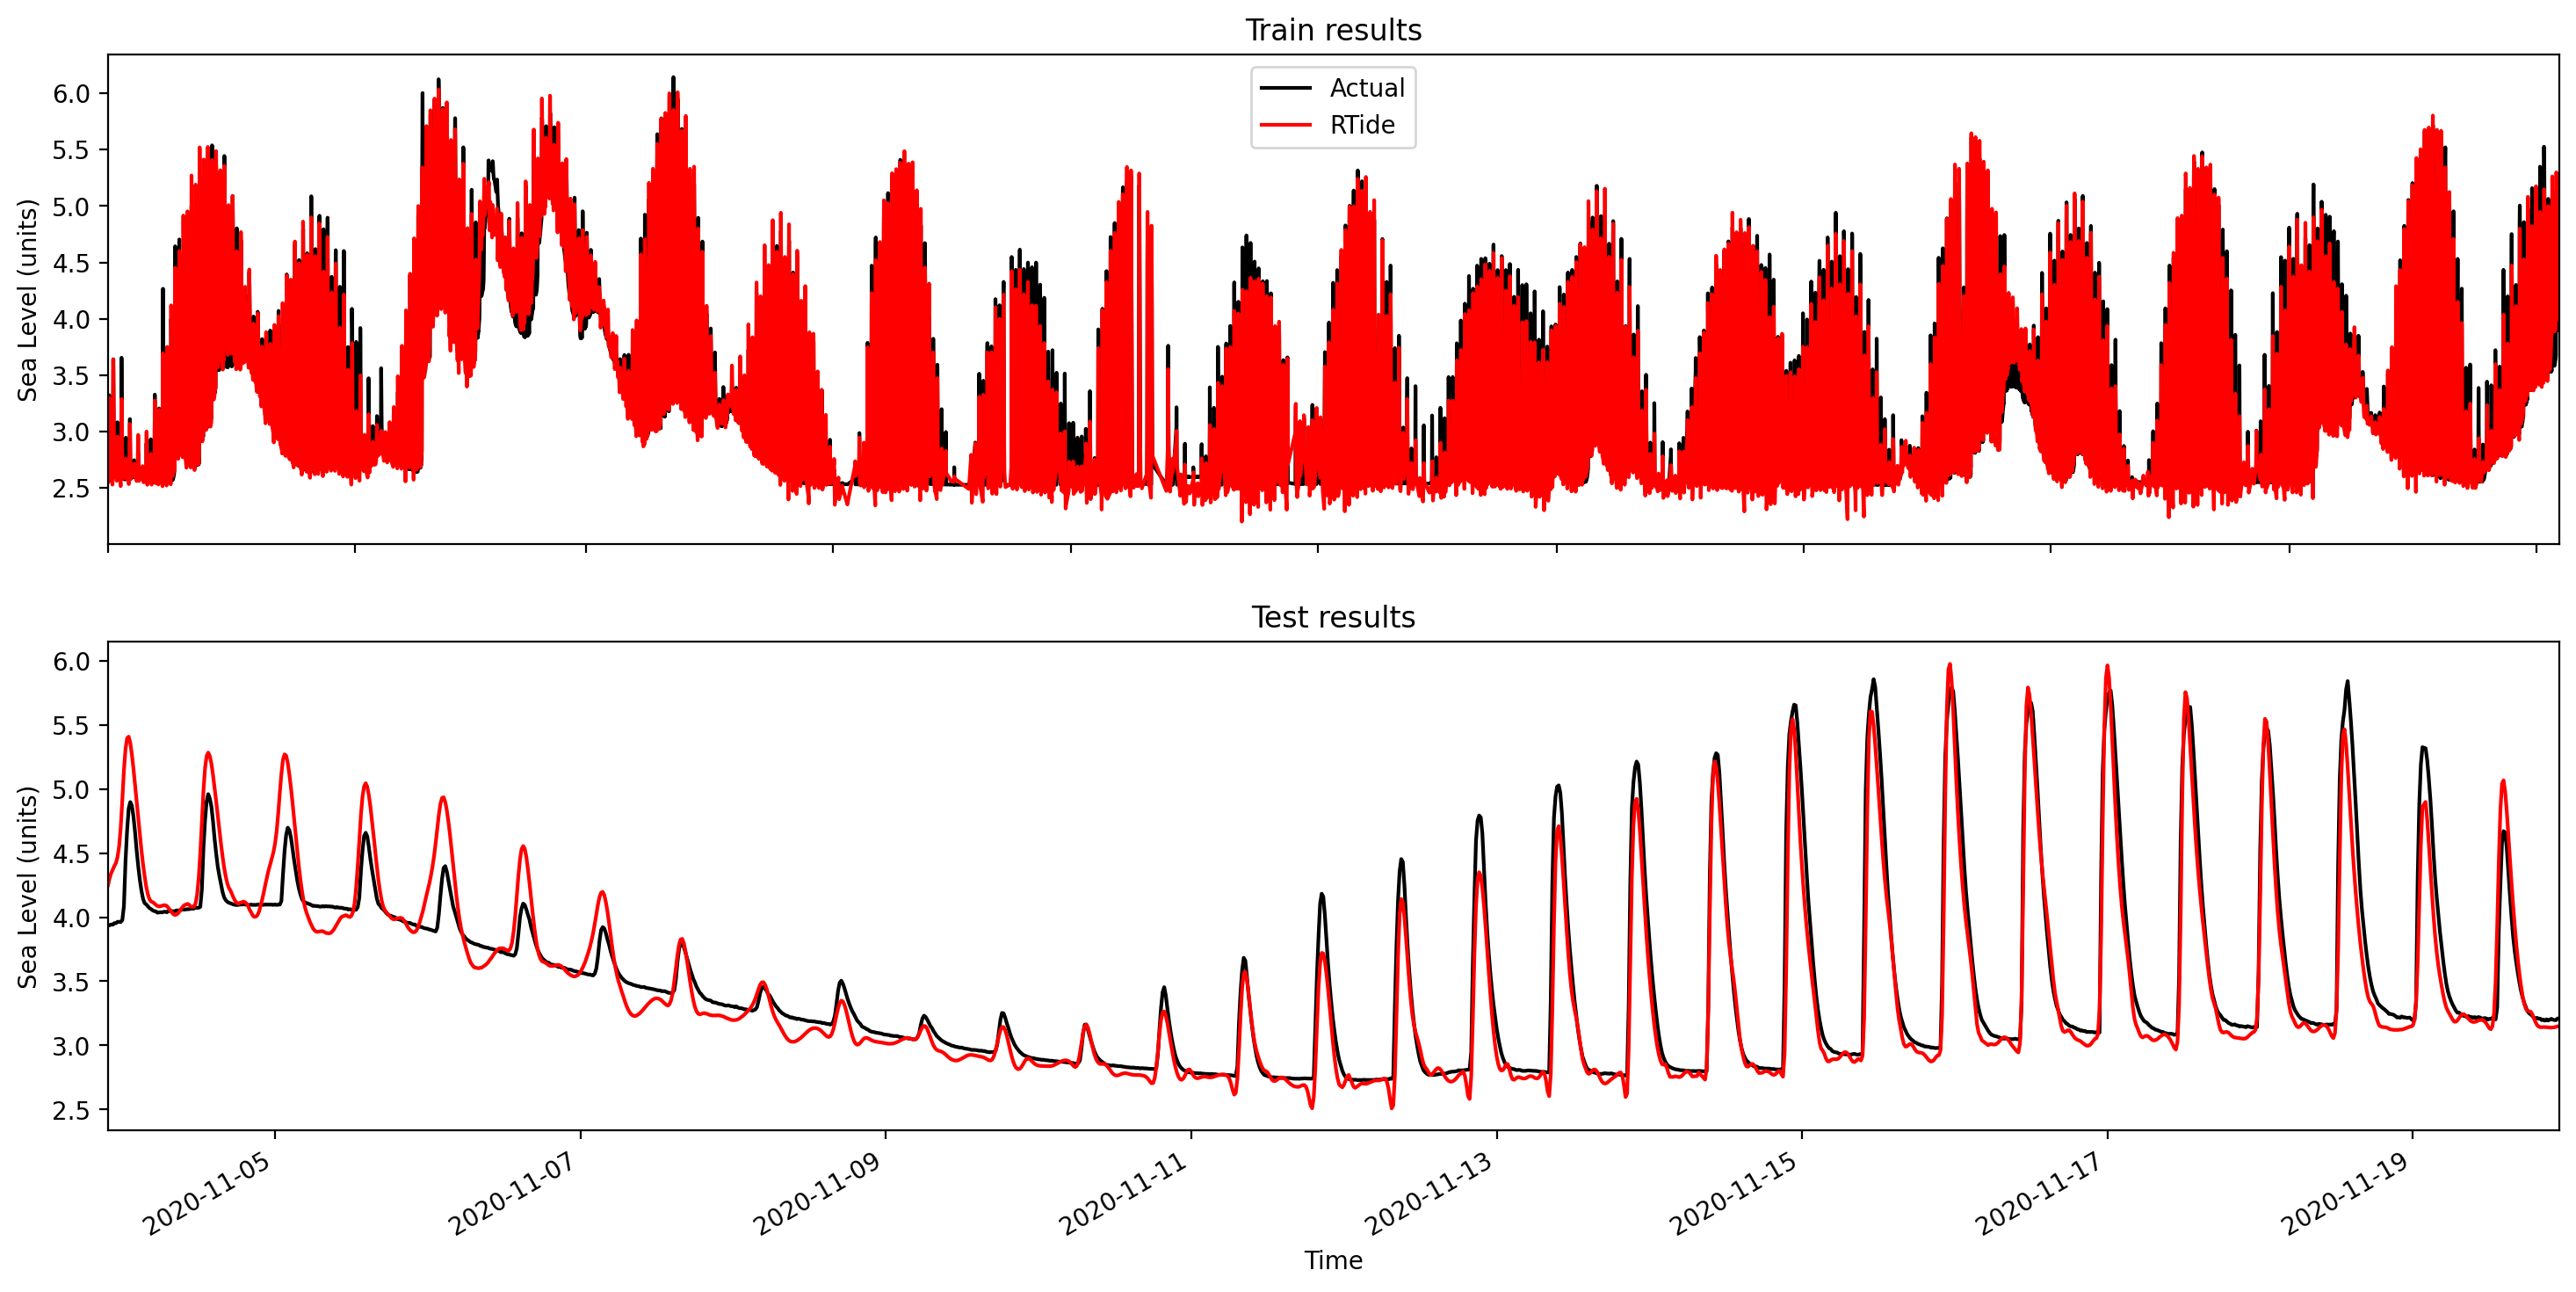

In [31]:
model.Visualize_Predictions()

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/1500 [00:00<?, ?it/s]

141/141 [==============================] - 0s 2ms/step


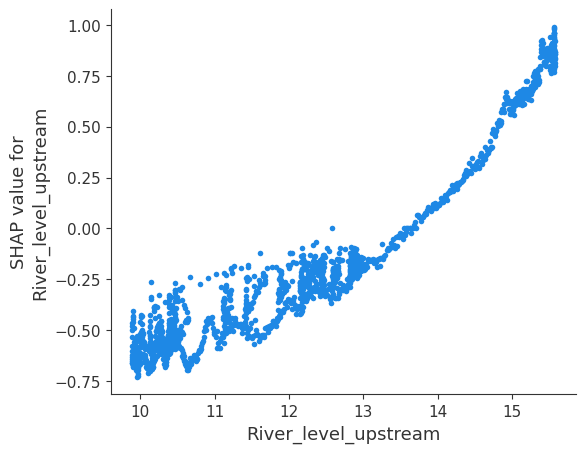

In [32]:
model.Shap_Analysis()